# DATASET
## 데이터셋설명
> 자동차 보험 청구 데이터 셋에는 보험 가입 기간, 자동차 연령, 자동차 소유자 연령, 도시의 인구 밀도, 자동차 제조업체 및 모델, 출력, 엔진 유형 등과 같은 속성을 가진 보험 계약자에 대한 정보와 이를 나타내는 대상 변수가 포함되며. 보험 계약자가 향후 6개월 이내에 청구서를 제출하는지 여부를 분류하기 위한 target이 있는 DATASET입니다.
### 익명처리를 거친 데이터로 고객의 개인정보와 관련된 피쳐들은 암호화가 되어있는 가상의 데이터셋입니다.

### [KAGGLE DATASET LINK](https://www.kaggle.com/datasets/ifteshanajnin/carinsuranceclaimprediction-classification)


In [1]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [129]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
app_train = pd.read_csv('./data/train.csv')
app_test = pd.read_csv('./data/test.csv')

In [3]:
app_train.shape, app_test.shape

((58592, 44), (39063, 43))

In [112]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [123]:
total = app_train[ app_train['is_claim']== 1 ].shape[0] + app_train[ app_train['is_claim']== 0 ].shape[0]
is_claim = app_train[ app_train['is_claim']== 1 ].shape[0]
not_is_claim = app_train[ app_train['is_claim']== 0 ].shape[0]

is_claim_rate = is_claim/total
not_is_claim_rate = not_is_claim/total

print(str(round(is_claim_rate,2) * 100)+"%")
print(str(round(not_is_claim_rate,2) * 100)+"%")

6.0%
94.0%


In [132]:
# 수치형,범주형 변수 분류
# 수치형 중 범주형을 단순 숫자로 나타낸 수치형 데이터타입 변경
app_train['gear_box'] = app_train['gear_box'].astype('object')
app_train['make'] = app_train['make'].astype('object')
app_train['airbags'] = app_train['airbags'].astype('object')
app_train['cylinder'] = app_train['cylinder'].astype('object')
app_train['ncap_rating'] = app_train['ncap_rating'].astype('object')

num_columns = app_train.dtypes[ (app_train.dtypes=='int64') | (app_train.dtypes=='float64')].index.tolist()
num_columns.remove('is_claim')

object_columns = app_train.dtypes[app_train.dtypes=='object'].index.tolist()

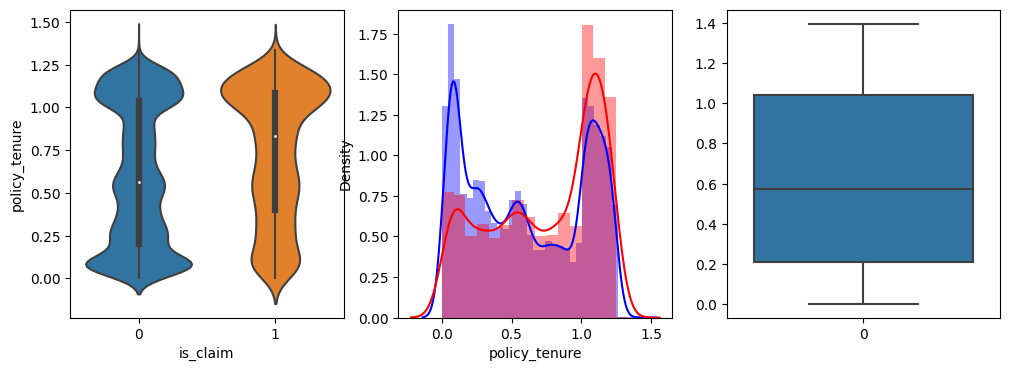

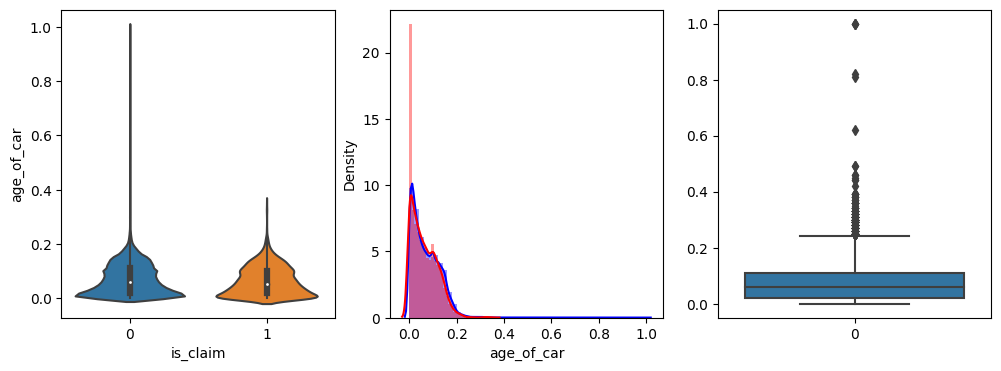

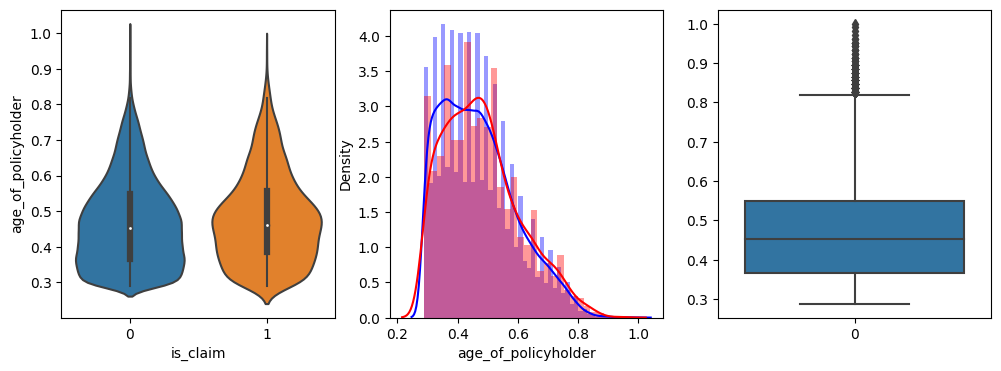

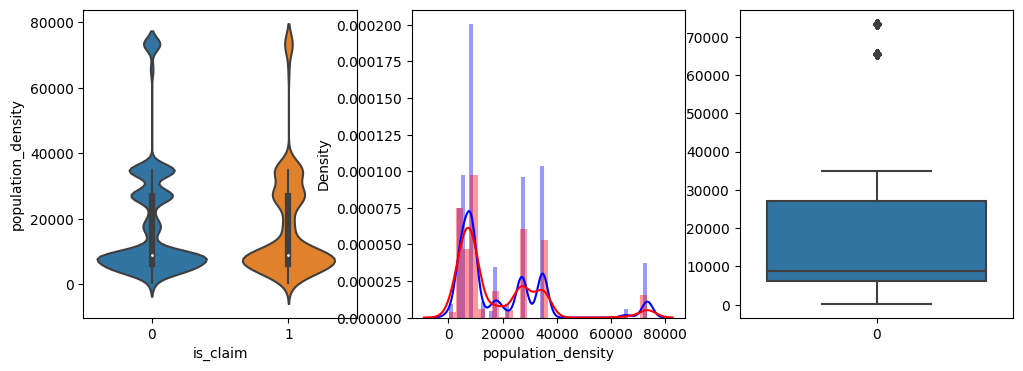

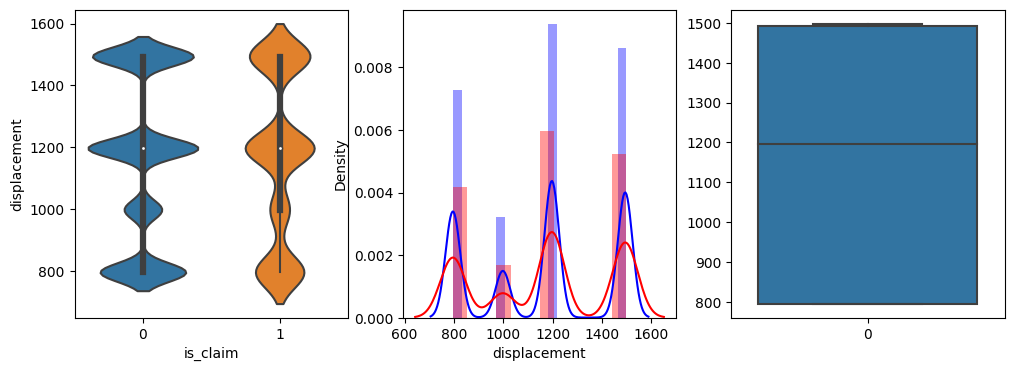

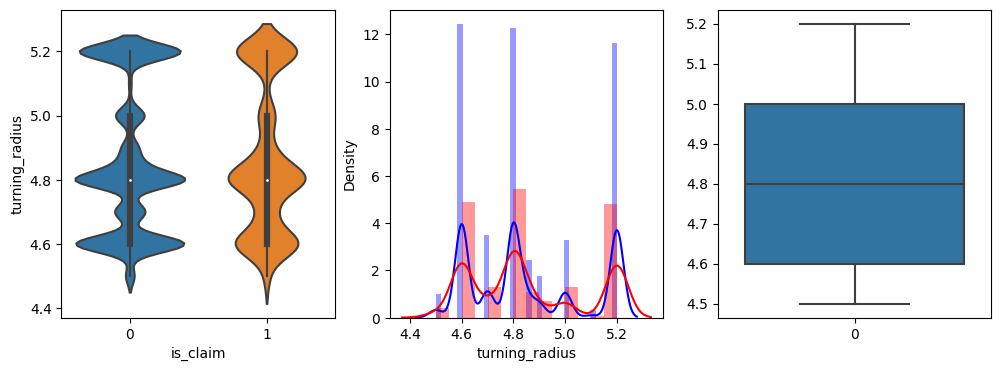

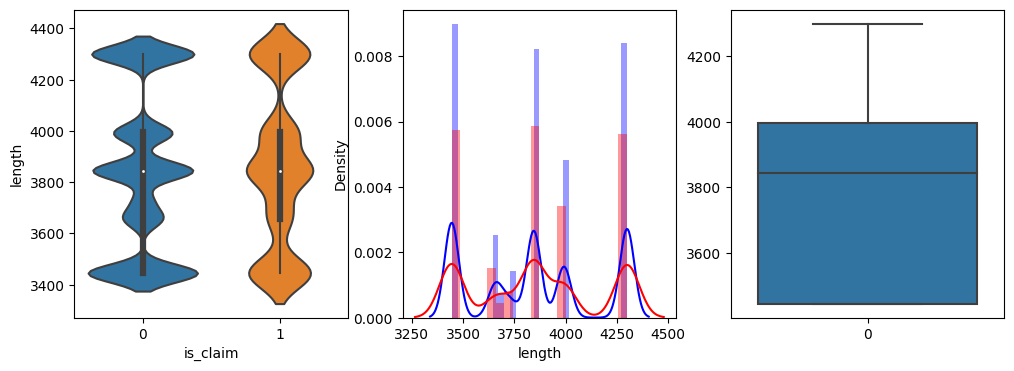

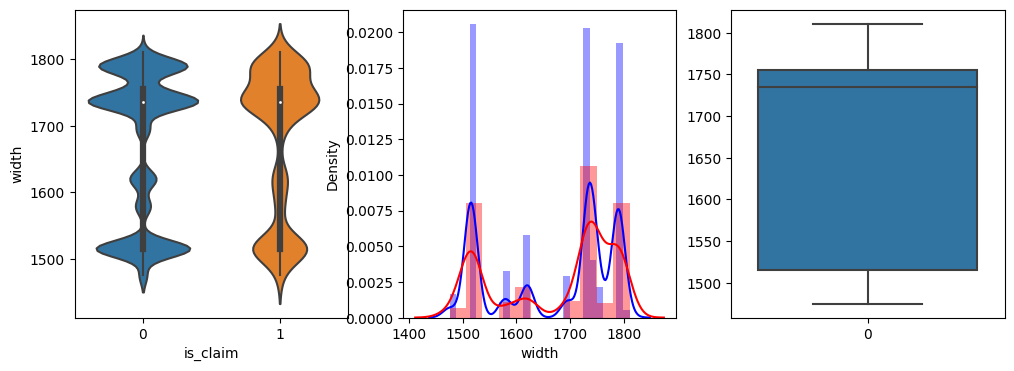

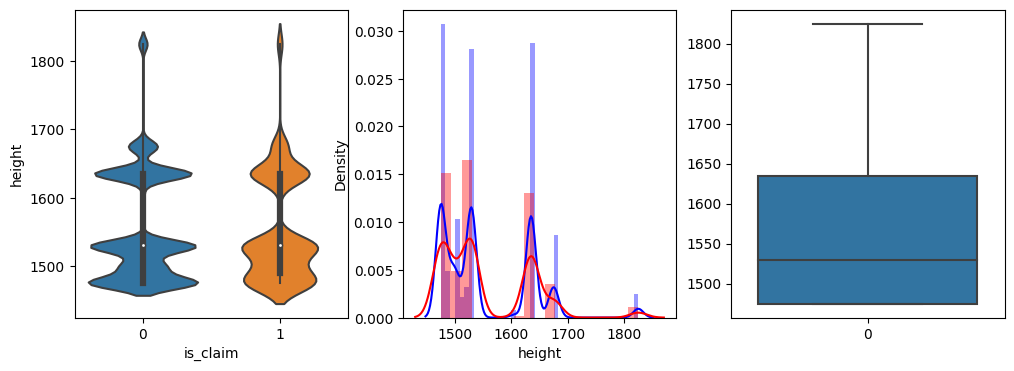

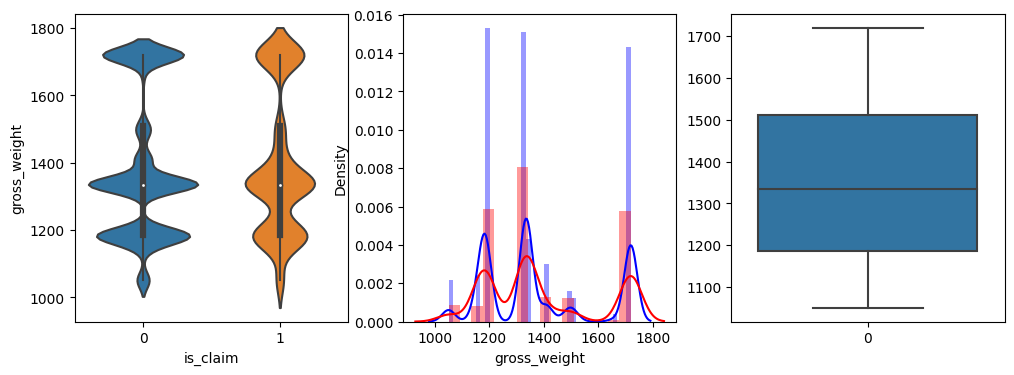

In [5]:
# numeric 변수 EDA시각화
# target인 is_claim으로 EDA
def show_outlier_hist_by_target(df, columns):
    cond_1 = (df['is_claim'] == 1)
    cond_0 = (df['is_claim'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), squeeze=False)
        sns.boxplot(app_train[column])
        sns.violinplot(x='is_claim', y=column, data=df, ax=axs[0][0] )
        sns.distplot(df[cond_0][column], ax=axs[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='red')

show_outlier_hist_by_target(app_train, num_columns)

In [6]:
# EDA를 통해 확인한 이상치 제거
app_train = app_train[ (app_train['population_density'] < 60000) |
                      (app_train['age_of_policyholder'] < 0.8) |
                      (app_train['age_of_car'] < 0.23) ]
app_train.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [133]:
object_columns

['policy_id',
 'area_cluster',
 'make',
 'segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'airbags',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'cylinder',
 'transmission_type',
 'gear_box',
 'steering_type',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert',
 'ncap_rating']

In [134]:
# object column으로 유의미하지 않은 58591개의 unique를 가진 feature 와 0or1개만을 가진 feature
# 제거
for object in object_columns:
    print(object, "의 value unique 수 : ",app_train[ object ].unique().argmax())

policy_id 의 value unique 수 :  58591
area_cluster 의 value unique 수 :  8
make 의 value unique 수 :  4
segment 의 value unique 수 :  5
model 의 value unique 수 :  8
fuel_type 의 value unique 수 :  1
max_torque 의 value unique 수 :  2
max_power 의 value unique 수 :  6
engine_type 의 value unique 수 :  8
airbags 의 value unique 수 :  1
is_esc 의 value unique 수 :  1
is_adjustable_steering 의 value unique 수 :  1
is_tpms 의 value unique 수 :  1
is_parking_sensors 의 value unique 수 :  0
is_parking_camera 의 value unique 수 :  1
rear_brakes_type 의 value unique 수 :  0
cylinder 의 value unique 수 :  1
transmission_type 의 value unique 수 :  0
gear_box 의 value unique 수 :  1
steering_type 의 value unique 수 :  0
is_front_fog_lights 의 value unique 수 :  1
is_rear_window_wiper 의 value unique 수 :  1
is_rear_window_washer 의 value unique 수 :  1
is_rear_window_defogger 의 value unique 수 :  1
is_brake_assist 의 value unique 수 :  1
is_power_door_locks 의 value unique 수 :  1
is_central_locking 의 value unique 수 :  1
is_power_steering 의 value

In [9]:
object_columns.remove('policy_id')

for object in object_columns:
    if (app_train[ object ].unique().argmax() > 1):
        pass
    else:
        app_train = app_train.drop(columns=object)
        app_test = app_test.drop(columns=object)

In [10]:
# 수치형,범주형 변수 전처리 후 데이터 info
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39063 entries, 0 to 39062
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   policy_id            39063 non-null  object 
 1   policy_tenure        39063 non-null  float64
 2   age_of_car           39063 non-null  float64
 3   age_of_policyholder  39063 non-null  float64
 4   area_cluster         39063 non-null  object 
 5   population_density   39063 non-null  int64  
 6   make                 39063 non-null  int64  
 7   segment              39063 non-null  object 
 8   model                39063 non-null  object 
 9   max_torque           39063 non-null  object 
 10  max_power            39063 non-null  object 
 11  engine_type          39063 non-null  object 
 12  displacement         39063 non-null  int64  
 13  turning_radius       39063 non-null  float64
 14  length               39063 non-null  int64  
 15  width                39063 non-null 

In [11]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   policy_id            58592 non-null  object 
 1   policy_tenure        58592 non-null  float64
 2   age_of_car           58592 non-null  float64
 3   age_of_policyholder  58592 non-null  float64
 4   area_cluster         58592 non-null  object 
 5   population_density   58592 non-null  int64  
 6   make                 58592 non-null  object 
 7   segment              58592 non-null  object 
 8   model                58592 non-null  object 
 9   max_torque           58592 non-null  object 
 10  max_power            58592 non-null  object 
 11  engine_type          58592 non-null  object 
 12  displacement         58592 non-null  int64  
 13  turning_radius       58592 non-null  float64
 14  length               58592 non-null  int64  
 15  width                58592 non-null 

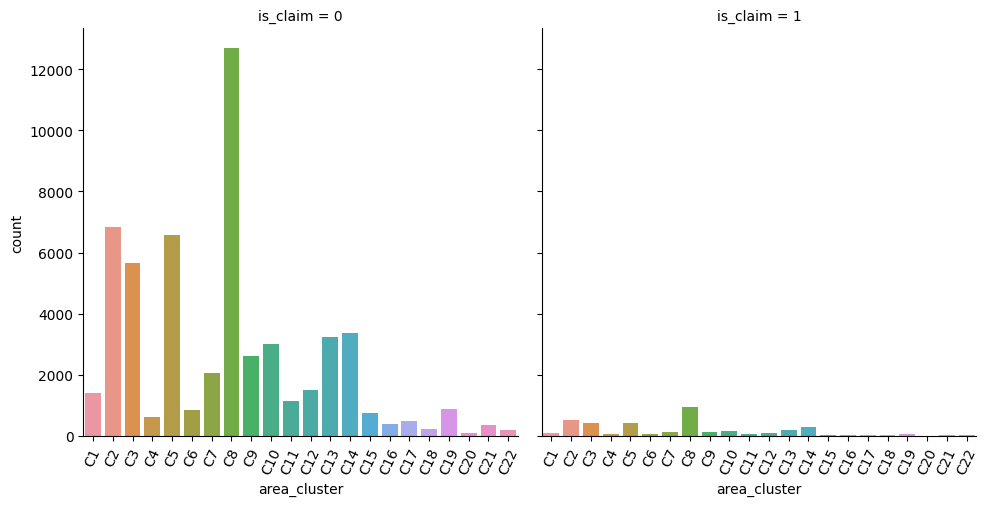

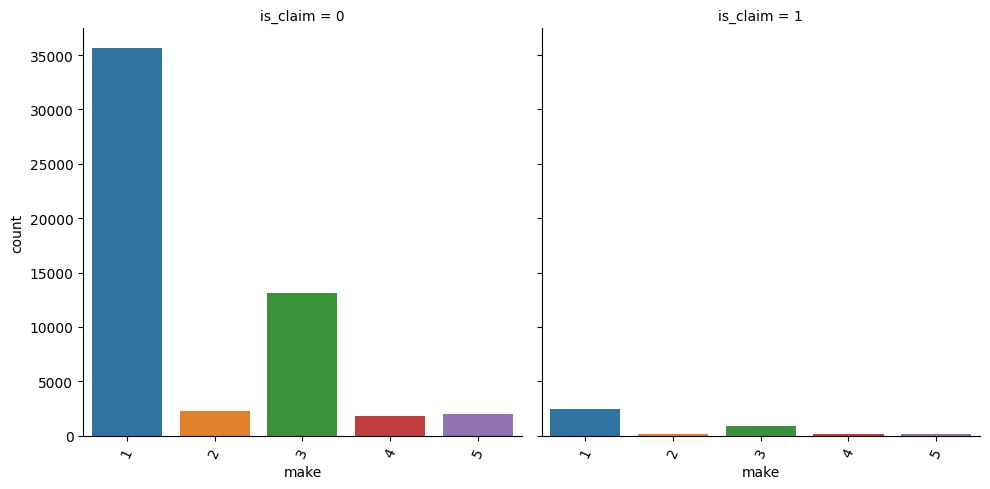

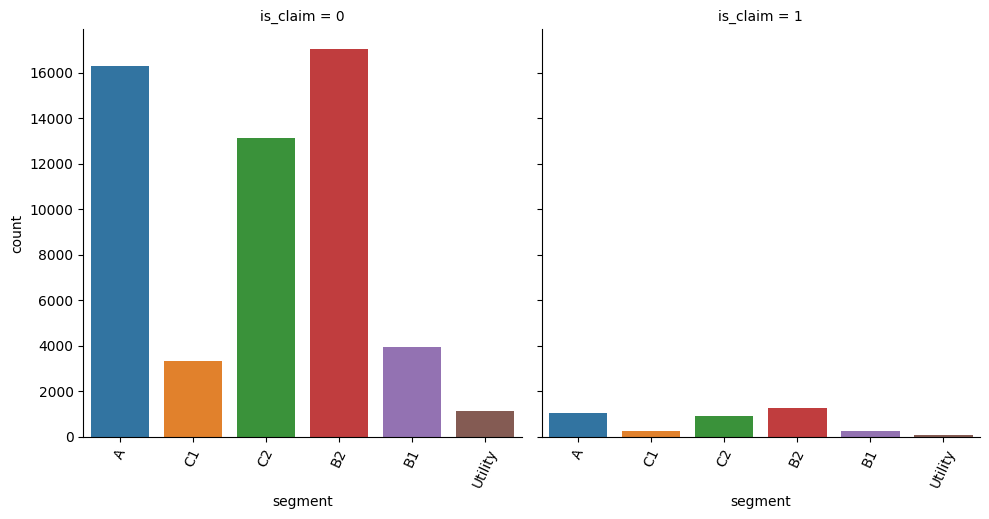

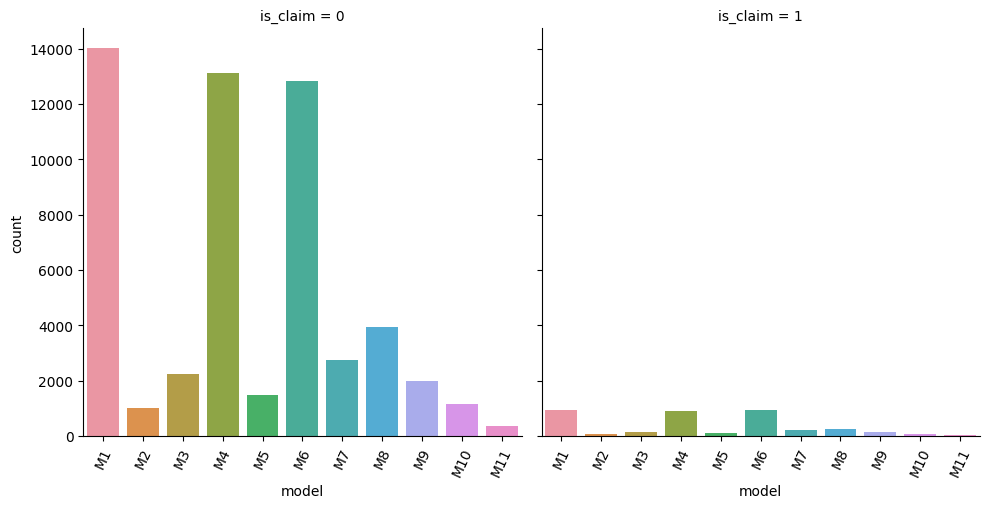

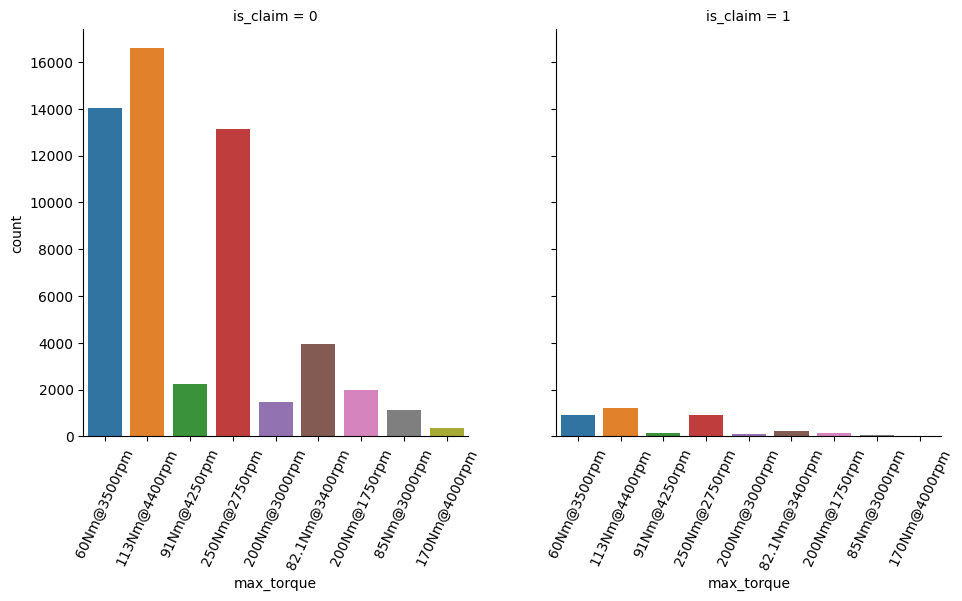

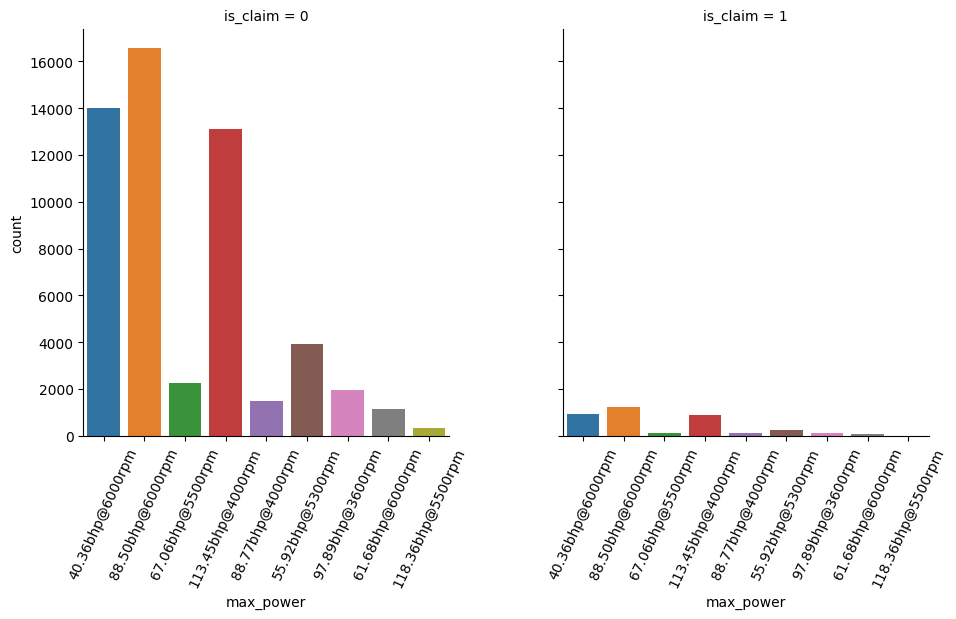

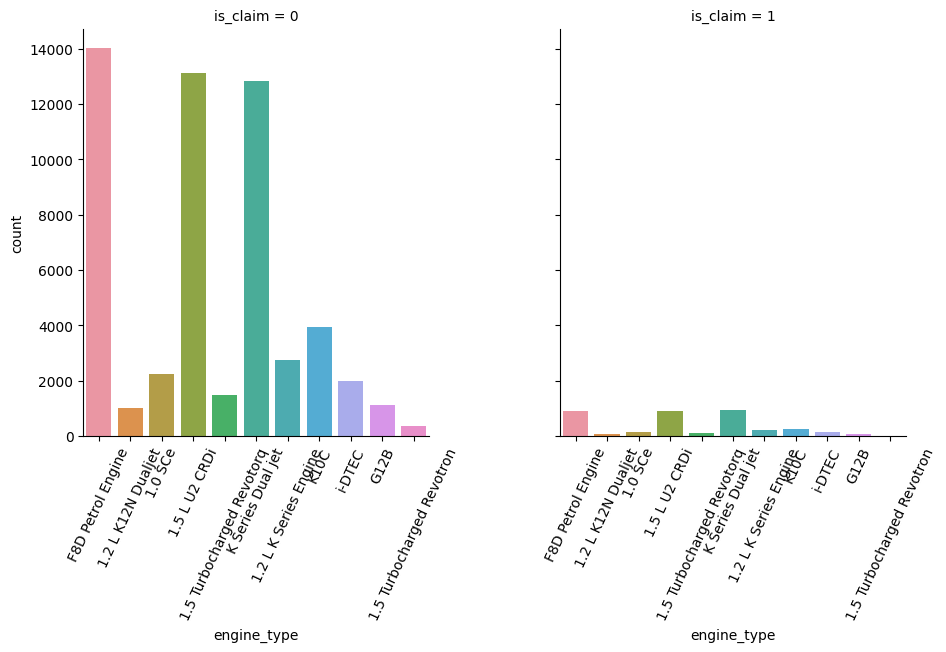

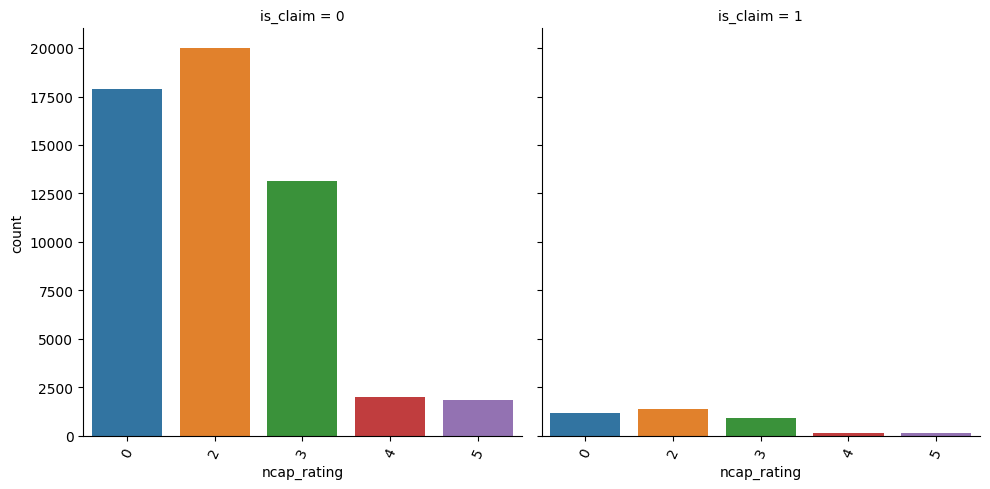

In [12]:
object_columns = app_train.dtypes[app_train.dtypes=='object'].index.tolist()
object_columns.remove('policy_id')
# 범주형 변수 EDA를 위해 유의미하지않은 policy_id 제거

# catplot을 이용하여 TARGET별로 여러컬럼의 category 값 Histogram을 표현 
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="is_claim", data=df, kind="count")
        chart.set_xticklabels(rotation=65)
        
show_category_by_target(app_train, object_columns)

In [13]:
# pd.factorize()는 한개의 컬럼만 Label 인코딩이 가능하므로 object형 컬럼들을 iteration하면서 변환 수행. 
for column in object_columns:
    app_train[column] = pd.factorize(app_train[column])[0]

app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   policy_id            58592 non-null  object 
 1   policy_tenure        58592 non-null  float64
 2   age_of_car           58592 non-null  float64
 3   age_of_policyholder  58592 non-null  float64
 4   area_cluster         58592 non-null  int64  
 5   population_density   58592 non-null  int64  
 6   make                 58592 non-null  int64  
 7   segment              58592 non-null  int64  
 8   model                58592 non-null  int64  
 9   max_torque           58592 non-null  int64  
 10  max_power            58592 non-null  int64  
 11  engine_type          58592 non-null  int64  
 12  displacement         58592 non-null  int64  
 13  turning_radius       58592 non-null  float64
 14  length               58592 non-null  int64  
 15  width                58592 non-null 

In [14]:
# pd.factorize()는 한개의 컬럼만 Label 인코딩이 가능하므로 object형 컬럼들을 iteration하면서 변환 수행. 
for column in object_columns:
    app_test[column] = pd.factorize(app_test[column])[0]

app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39063 entries, 0 to 39062
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   policy_id            39063 non-null  object 
 1   policy_tenure        39063 non-null  float64
 2   age_of_car           39063 non-null  float64
 3   age_of_policyholder  39063 non-null  float64
 4   area_cluster         39063 non-null  int64  
 5   population_density   39063 non-null  int64  
 6   make                 39063 non-null  int64  
 7   segment              39063 non-null  int64  
 8   model                39063 non-null  int64  
 9   max_torque           39063 non-null  int64  
 10  max_power            39063 non-null  int64  
 11  engine_type          39063 non-null  int64  
 12  displacement         39063 non-null  int64  
 13  turning_radius       39063 non-null  float64
 14  length               39063 non-null  int64  
 15  width                39063 non-null 

In [15]:
app_train_x = app_train.drop(columns=['is_claim','policy_id'])
app_train_x_columns = app_train_x.columns

In [16]:
app_train_y = app_train['is_claim']

---
#### 좀더 정확한 범주형 변수 비교를 위해 is_claim=1 의 data 를 증가시키는 smote기법사용

In [17]:
sum(np.array(app_train_y==1))

3748

In [18]:
sum(np.array(app_train_y==0))

54844

In [19]:
app_train_x = app_train_x.values
app_train_y = app_train_y.values

In [20]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(app_train_x, list(app_train_y))

print('Before SMOTE, original X_train: {}'.format(app_train_x.shape))
print('Before SMOTE, original y_train: {}'.format(np.array(app_train_y).shape))

print('After  SMOTE, resampled original X_train: {}'.format(X_resampled.shape))
print('After  SMOTE, resampled original y_train: {} \n'.format(np.array(y_resampled).shape))

print("Before SMOTE,     is_claim counts: {}".format(sum(np.array(app_train_y)==1)))
print("Before SMOTE, non-claim counts: {}".format(sum(np.array(app_train_y)==0)))

print("After  SMOTE,     is_claim counts: {}".format(sum(np.array(y_resampled)==1)))
print("After  SMOTE, non-claim counts: {}".format(sum(np.array(y_resampled)==0)))

Before SMOTE, original X_train: (58592, 18)
Before SMOTE, original y_train: (58592,)
After  SMOTE, resampled original X_train: (109688, 18)
After  SMOTE, resampled original y_train: (109688,) 

Before SMOTE,     is_claim counts: 3748
Before SMOTE, non-claim counts: 54844
After  SMOTE,     is_claim counts: 54844
After  SMOTE, non-claim counts: 54844


In [21]:
smote_train_x = pd.DataFrame(X_resampled)
smote_train_x.columns = app_train_x_columns
smote_train_x


,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,max_torque,max_power,engine_type,displacement,turning_radius,length,width,height,gross_weight,ncap_rating
0,0.515874,0.050000,0.644231,0.0,4990.0,0.0,0.0,0.0,0.0,0.0,0.0,796.0,4.60,3445.0,1515.0,1475.0,1185.0,0.0
1,0.672619,0.020000,0.375000,1.0,27003.0,0.0,0.0,0.0,0.0,0.0,0.0,796.0,4.60,3445.0,1515.0,1475.0,1185.0,0.0
2,0.841110,0.020000,0.384615,2.0,4076.0,0.0,0.0,0.0,0.0,0.0,0.0,796.0,4.60,3445.0,1515.0,1475.0,1185.0,0.0
3,0.900277,0.110000,0.432692,3.0,21622.0,0.0,1.0,1.0,1.0,1.0,1.0,1197.0,4.80,3995.0,1735.0,1515.0,1335.0,1.0
4,0.596403,0.110000,0.634615,4.0,34738.0,1.0,0.0,2.0,2.0,2.0,2.0,999.0,5.00,3731.0,1579.0,1490.0,1155.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109683,0.634914,0.093904,0.564805,2.0,4076.0,2.0,2.0,3.0,3.0,3.0,3.0,1493.0,5.20,4300.0,1790.0,1635.0,1720.0,2.0
109684,1.030452,0.076874,0.405349,7.0,8794.0,0.0,3.0,6.0,1.0,1.0,6.0,1197.0,4.85,3990.0,1745.0,1500.0,1410.0,0.0
109685,0.966897,0.108805,0.395380,10.0,6108.0,0.0,3.0,5.0,1.0,1.0,5.0,1197.0,4.80,3845.0,1735.0,1530.0,1335.0,1.0
109686,0.716756,0.040000,0.708154,4.0,34738.0,0.0,0.0,0.0,0.0,0.0,0.0,796.0,4.60,3445.0,1515.0,1475.0,1185.0,0.0


In [22]:
smote_train_y = pd.DataFrame(y_resampled)
smote_train_y.columns = ['is_claim']
smote_train_y

,is_claim
0,0
1,0
2,0
3,0
4,0
...,...
109683,1
109684,1
109685,1
109686,1


In [23]:
smote_train = pd.concat([smote_train_x,smote_train_y], axis=1)
smote_train

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,max_torque,max_power,engine_type,displacement,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
0,0.515874,0.050000,0.644231,0.0,4990.0,0.0,0.0,0.0,0.0,0.0,0.0,796.0,4.60,3445.0,1515.0,1475.0,1185.0,0.0,0
1,0.672619,0.020000,0.375000,1.0,27003.0,0.0,0.0,0.0,0.0,0.0,0.0,796.0,4.60,3445.0,1515.0,1475.0,1185.0,0.0,0
2,0.841110,0.020000,0.384615,2.0,4076.0,0.0,0.0,0.0,0.0,0.0,0.0,796.0,4.60,3445.0,1515.0,1475.0,1185.0,0.0,0
3,0.900277,0.110000,0.432692,3.0,21622.0,0.0,1.0,1.0,1.0,1.0,1.0,1197.0,4.80,3995.0,1735.0,1515.0,1335.0,1.0,0
4,0.596403,0.110000,0.634615,4.0,34738.0,1.0,0.0,2.0,2.0,2.0,2.0,999.0,5.00,3731.0,1579.0,1490.0,1155.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109683,0.634914,0.093904,0.564805,2.0,4076.0,2.0,2.0,3.0,3.0,3.0,3.0,1493.0,5.20,4300.0,1790.0,1635.0,1720.0,2.0,1
109684,1.030452,0.076874,0.405349,7.0,8794.0,0.0,3.0,6.0,1.0,1.0,6.0,1197.0,4.85,3990.0,1745.0,1500.0,1410.0,0.0,1
109685,0.966897,0.108805,0.395380,10.0,6108.0,0.0,3.0,5.0,1.0,1.0,5.0,1197.0,4.80,3845.0,1735.0,1530.0,1335.0,1.0,1
109686,0.716756,0.040000,0.708154,4.0,34738.0,0.0,0.0,0.0,0.0,0.0,0.0,796.0,4.60,3445.0,1515.0,1475.0,1185.0,0.0,1


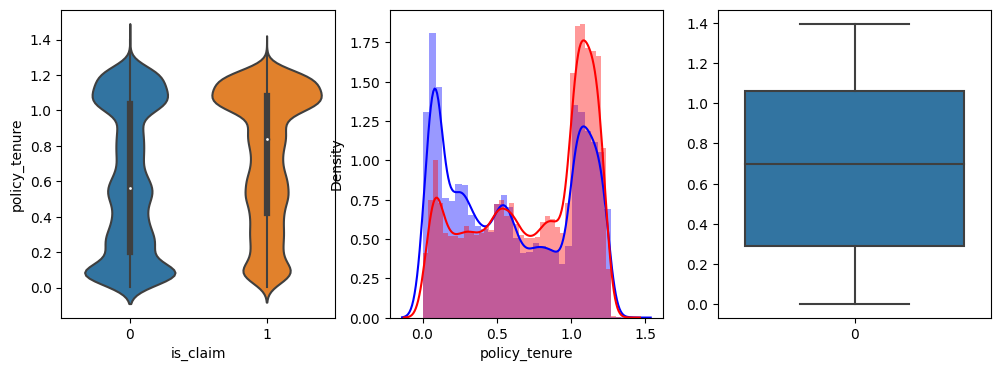

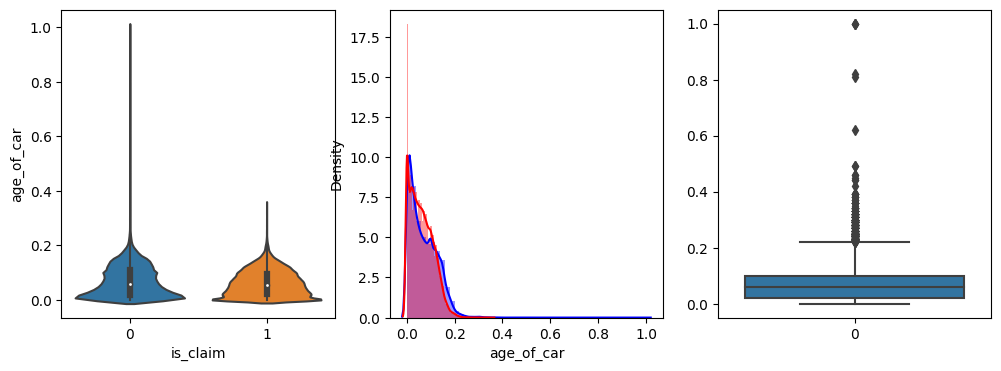

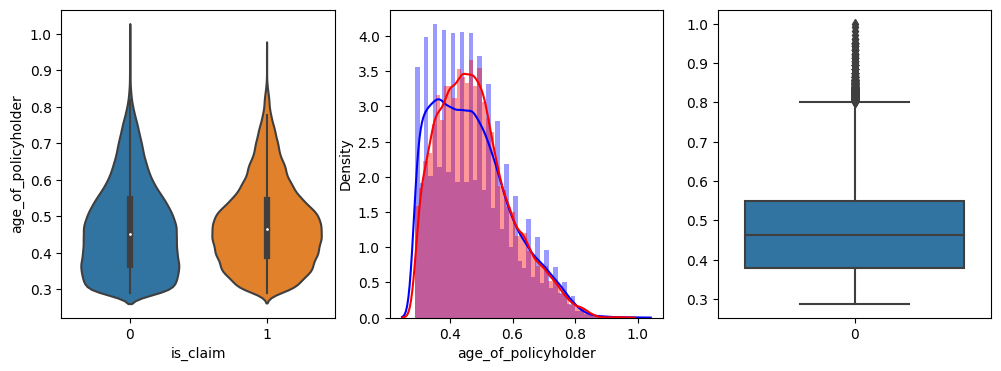

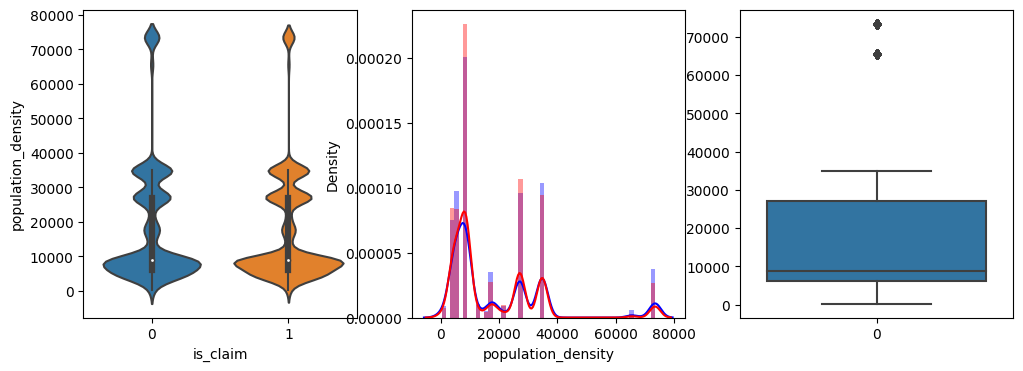

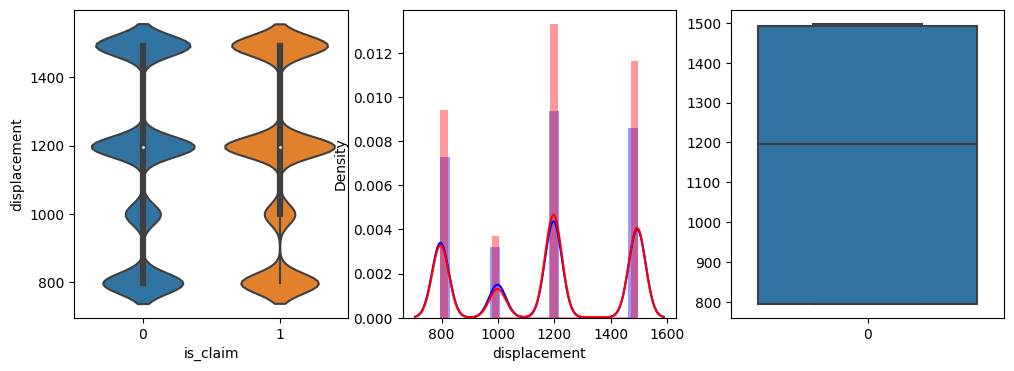

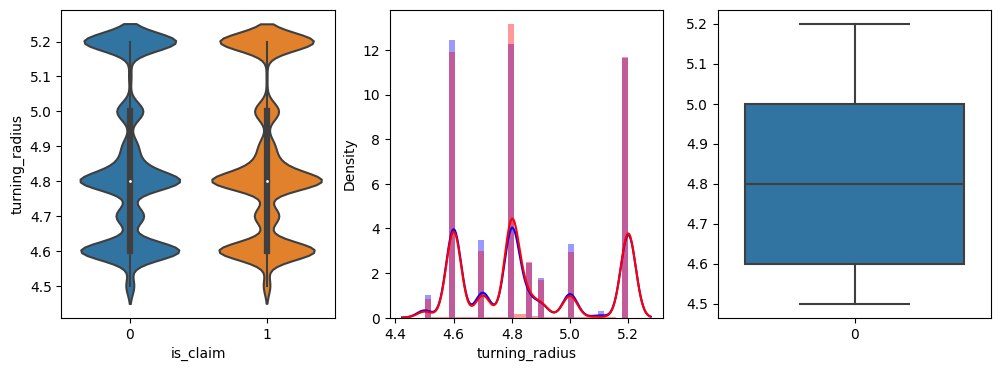

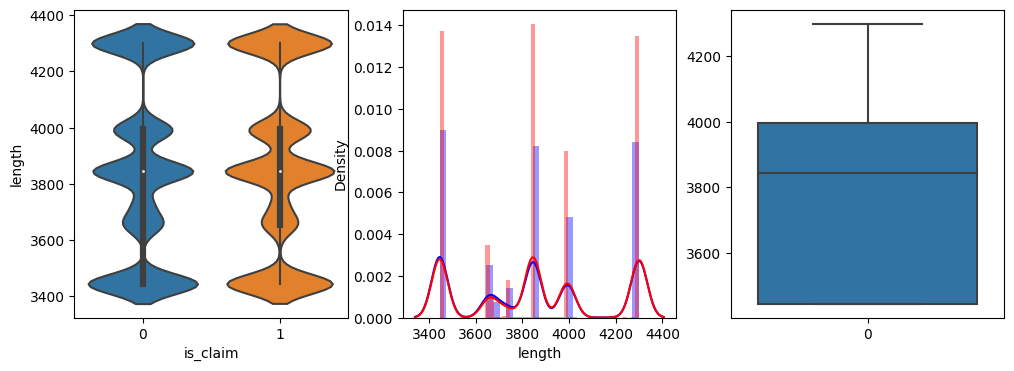

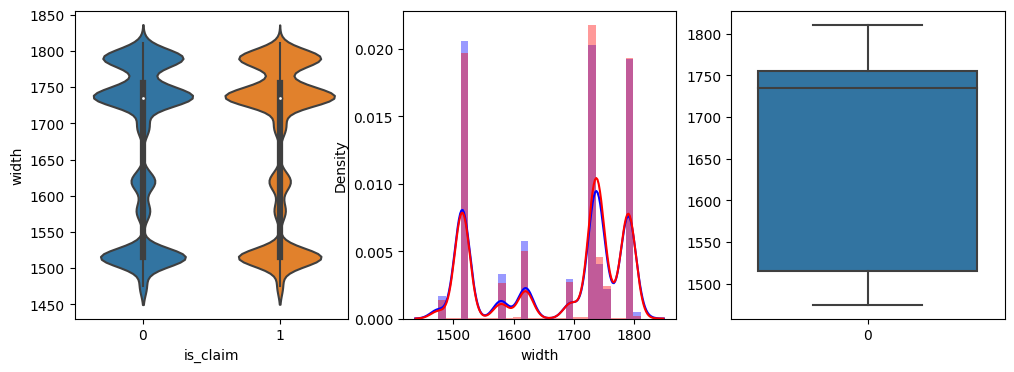

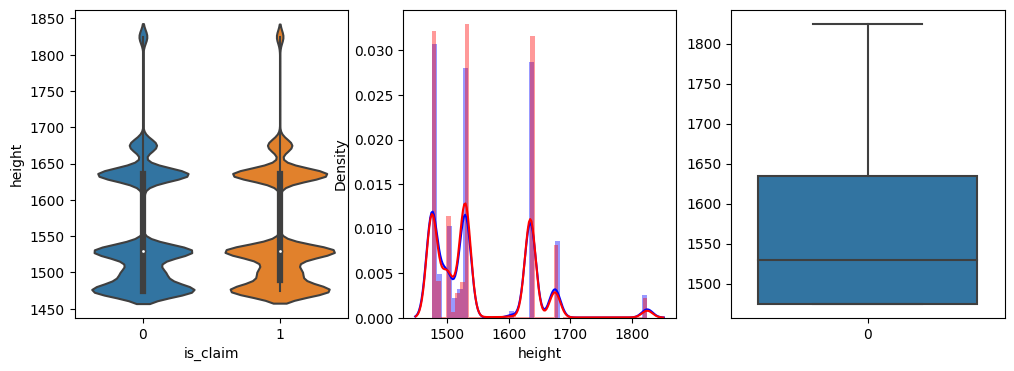

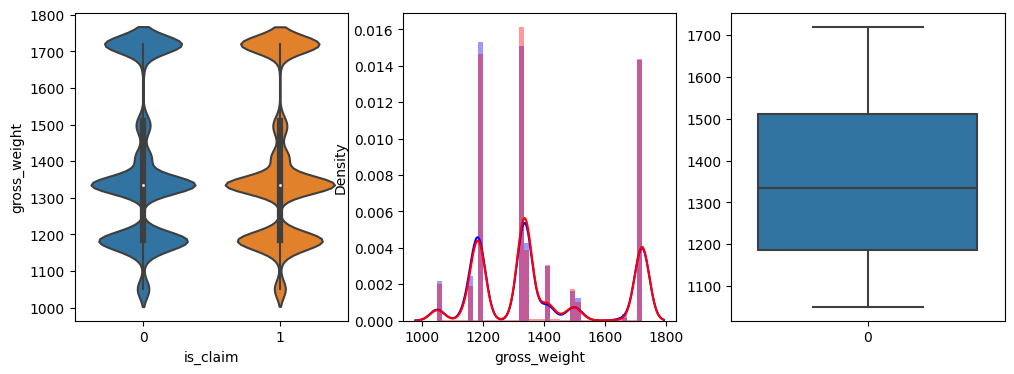

In [24]:
# numeric 변수 EDA시각화
# target인 is_claim으로 EDA
def show_outlier_hist_by_target(df, columns):
    cond_1 = (df['is_claim'] == 1)
    cond_0 = (df['is_claim'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), squeeze=False)
        sns.boxplot(smote_train[column])
        sns.violinplot(x='is_claim', y=column, data=df, ax=axs[0][0] )
        sns.distplot(df[cond_0][column], ax=axs[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='red')

show_outlier_hist_by_target(smote_train, num_columns)

----
#### 파생변수 생성 및 다중공선성 고려 높은 상관관계 피쳐들 제거

<Axes: >

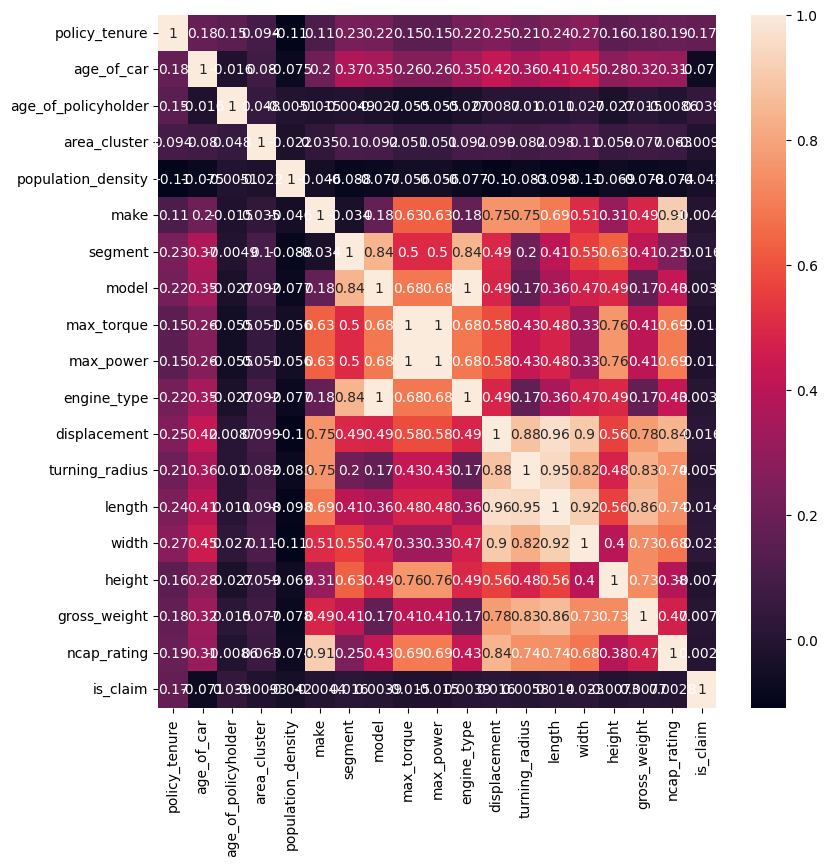

In [25]:
corr = smote_train.corr()

plt.figure(figsize=(9, 9))
sns.heatmap(corr, annot=True)

## 

engine type model 다중공선성
max_torque max_power 다중공선성 

-둘중 하나 제외

displacement 배기량
turning_radius 필요회전반경
length 길이
width 너비
- 하나로


In [26]:
smote_train.drop(columns= ['engine_type','max_power'] ,inplace=True)
smote_train['car_size'] = (smote_train['displacement'] + smote_train['turning_radius'] + smote_train['length'] + smote_train['width'])

In [27]:
smote_train['car_size']

0         5760.60
1         5760.60
2         5760.60
3         6931.80
4         6314.00
           ...   
109683    7588.20
109684    6936.85
109685    6781.80
109686    5760.60
109687    5760.60
Name: car_size, Length: 109688, dtype: float64

In [28]:
smote_train.drop(columns=['displacement',
'turning_radius',
'length',
'width'], inplace=True)

<Axes: >

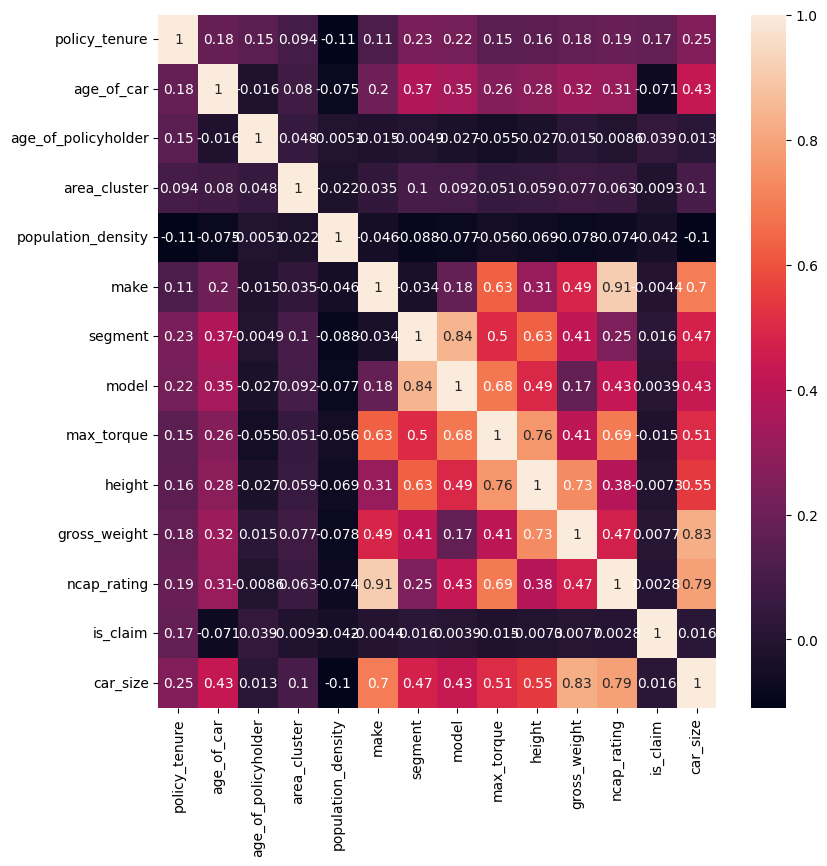

In [29]:
corr = smote_train.corr()

plt.figure(figsize=(9, 9))
sns.heatmap(corr, annot=True)

In [30]:
smote_train_x = smote_train.drop(columns='is_claim', axis=1)

smote_train_y = smote_train['is_claim']

In [31]:
app_test.drop(columns= ['policy_id','engine_type','max_power'] ,inplace=True)
app_test['car_size'] = (app_test['displacement'] + app_test['turning_radius'] + app_test['length'] + app_test['width'])

app_test.drop(columns=['displacement',
'turning_radius',
'length',
'width'], inplace=True)

In [32]:
app_test

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,max_torque,height,gross_weight,ncap_rating,car_size
0,0.341732,0.00,0.586538,0,4076,0,0,0,0,1475,1185,0,5760.60
1,0.307241,0.13,0.442308,1,8794,0,1,1,1,1530,1335,1,6781.80
2,0.327924,0.12,0.451923,1,8794,1,0,2,2,1490,1155,1,6314.00
3,0.782654,0.01,0.461538,2,34738,0,0,0,0,1475,1185,0,5760.60
4,1.233404,0.02,0.634615,2,34738,0,0,0,0,1475,1185,0,5760.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39058,0.047982,0.15,0.740385,6,27003,0,1,1,1,1530,1335,1,6781.80
39059,1.224838,0.05,0.509615,1,8794,2,3,5,4,1635,1720,2,7588.20
39060,0.520287,0.12,0.355769,13,13051,0,1,3,1,1500,1410,0,6936.85
39061,1.172391,0.08,0.644231,2,34738,0,4,8,1,1515,1335,1,6931.80


---
Scaler

In [33]:
smote_scale_feature =[
 'age_of_car',
 'population_density',
 'height',
 'gross_weight',
 'car_size']

In [34]:
smote_train_x_mm = smote_train_x.copy()
smote_train_x_st = smote_train_x.copy()
smote_train_x_rb = smote_train_x.copy()

In [35]:
app_test_mm = app_test.copy()
app_test_st = app_test.copy()
app_test_rb = app_test.copy()

In [36]:
# 데이터 스케일 조정하기
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler() ##

for feature in smote_scale_feature:
    smote_train_x_mm['scaled_{}'.format(feature)] = mm_scaler.fit_transform(smote_train_x_mm[feature].values.reshape(-1,1))
    smote_train_x_st['scaled_{}'.format(feature)] = std_scaler.fit_transform(smote_train_x_st[feature].values.reshape(-1,1))
    smote_train_x_rb['scaled_{}'.format(feature)] = rob_scaler.fit_transform(smote_train_x_rb[feature].values.reshape(-1,1))

In [37]:
# 데이터 스케일 조정하기
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler() ##

for feature in smote_scale_feature:
    app_test_mm['scaled_{}'.format(feature)] = mm_scaler.fit_transform(app_test_mm[feature].values.reshape(-1,1))
    app_test_st['scaled_{}'.format(feature)] = std_scaler.fit_transform(app_test_st[feature].values.reshape(-1,1))
    app_test_rb['scaled_{}'.format(feature)] = rob_scaler.fit_transform(app_test_rb[feature].values.reshape(-1,1))

In [38]:
smote_train_x_mm

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,max_torque,height,gross_weight,ncap_rating,car_size,scaled_age_of_car,scaled_population_density,scaled_height,scaled_gross_weight,scaled_car_size
0,0.515874,0.050000,0.644231,0.0,4990.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,0.050000,0.064260,0.000000,0.200299,0.000000
1,0.672619,0.020000,0.375000,1.0,27003.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,0.020000,0.365231,0.000000,0.200299,0.000000
2,0.841110,0.020000,0.384615,2.0,4076.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,0.020000,0.051764,0.000000,0.200299,0.000000
3,0.900277,0.110000,0.432692,3.0,21622.0,0.0,1.0,1.0,1.0,1515.0,1335.0,1.0,6931.80,0.110000,0.291660,0.114286,0.424514,0.640840
4,0.596403,0.110000,0.634615,4.0,34738.0,1.0,0.0,2.0,2.0,1490.0,1155.0,1.0,6314.00,0.110000,0.470987,0.042857,0.155456,0.302801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109683,0.634914,0.093904,0.564805,2.0,4076.0,2.0,2.0,3.0,3.0,1635.0,1720.0,2.0,7588.20,0.093904,0.051764,0.457143,1.000000,1.000000
109684,1.030452,0.076874,0.405349,7.0,8794.0,0.0,3.0,6.0,1.0,1500.0,1410.0,0.0,6936.85,0.076874,0.116270,0.071429,0.536622,0.643604
109685,0.966897,0.108805,0.395380,10.0,6108.0,0.0,3.0,5.0,1.0,1530.0,1335.0,1.0,6781.80,0.108805,0.079546,0.157143,0.424514,0.558766
109686,0.716756,0.040000,0.708154,4.0,34738.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,0.040000,0.470987,0.000000,0.200299,0.000000


In [39]:
smote_train_x_st

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,max_torque,height,gross_weight,ncap_rating,car_size,scaled_age_of_car,scaled_population_density,scaled_height,scaled_gross_weight,scaled_car_size
0,0.515874,0.050000,0.644231,0.0,4990.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,-0.307308,-0.781021,-0.992224,-0.954768,-1.394626
1,0.672619,0.020000,0.375000,1.0,27003.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,-0.879236,0.520240,-0.992224,-0.954768,-1.394626
2,0.841110,0.020000,0.384615,2.0,4076.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,-0.879236,-0.835051,-0.992224,-0.954768,-1.394626
3,0.900277,0.110000,0.432692,3.0,21622.0,0.0,1.0,1.0,1.0,1515.0,1335.0,1.0,6931.80,0.836548,0.202152,-0.482135,-0.244660,0.344783
4,0.596403,0.110000,0.634615,4.0,34738.0,1.0,0.0,2.0,2.0,1490.0,1155.0,1.0,6314.00,0.836548,0.977482,-0.800941,-1.096790,-0.572743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109683,0.634914,0.093904,0.564805,2.0,4076.0,2.0,2.0,3.0,3.0,1635.0,1720.0,2.0,7588.20,0.529699,-0.835051,1.048132,1.577951,1.319636
109684,1.030452,0.076874,0.405349,7.0,8794.0,0.0,3.0,6.0,1.0,1500.0,1410.0,0.0,6936.85,0.205019,-0.556154,-0.673419,0.110394,0.352283
109685,0.966897,0.108805,0.395380,10.0,6108.0,0.0,3.0,5.0,1.0,1530.0,1335.0,1.0,6781.80,0.813771,-0.714933,-0.290852,-0.244660,0.122010
109686,0.716756,0.040000,0.708154,4.0,34738.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,-0.497951,0.977482,-0.992224,-0.954768,-1.394626


In [40]:
smote_train_x_rb

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,max_torque,height,gross_weight,ncap_rating,car_size,scaled_age_of_car,scaled_population_density,scaled_height,scaled_gross_weight,scaled_car_size
0,0.515874,0.050000,0.644231,0.0,4990.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,-0.117354,-0.182088,-0.34375,-0.461538,-0.687029
1,0.672619,0.020000,0.375000,1.0,27003.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,-0.492354,0.871619,-0.34375,-0.461538,-0.687029
2,0.841110,0.020000,0.384615,2.0,4076.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,-0.492354,-0.225839,-0.34375,-0.461538,-0.687029
3,0.900277,0.110000,0.432692,3.0,21622.0,0.0,1.0,1.0,1.0,1515.0,1335.0,1.0,6931.80,0.632646,0.614044,-0.09375,0.000000,0.100915
4,0.596403,0.110000,0.634615,4.0,34738.0,1.0,0.0,2.0,2.0,1490.0,1155.0,1.0,6314.00,0.632646,1.241874,-0.25000,-0.553846,-0.314720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109683,0.634914,0.093904,0.564805,2.0,4076.0,2.0,2.0,3.0,3.0,1635.0,1720.0,2.0,7588.20,0.431451,-0.225839,0.65625,1.184615,0.542519
109684,1.030452,0.076874,0.405349,7.0,8794.0,0.0,3.0,6.0,1.0,1500.0,1410.0,0.0,6936.85,0.218567,0.000000,-0.18750,0.230769,0.104312
109685,0.966897,0.108805,0.395380,10.0,6108.0,0.0,3.0,5.0,1.0,1530.0,1335.0,1.0,6781.80,0.617711,-0.128572,0.00000,0.000000,0.000000
109686,0.716756,0.040000,0.708154,4.0,34738.0,0.0,0.0,0.0,0.0,1475.0,1185.0,0.0,5760.60,-0.242354,1.241874,-0.34375,-0.461538,-0.687029


In [41]:
# 원 데이터에서 scale된 컬럼제거
smote_train_x_mm.drop(smote_scale_feature , axis=1, inplace=True)
smote_train_x_st.drop(smote_scale_feature , axis=1, inplace=True)
smote_train_x_rb.drop(smote_scale_feature , axis=1, inplace=True)

In [42]:
# 원 데이터에서 scale된 컬럼제거
app_test_mm.drop(smote_scale_feature , axis=1, inplace=True)
app_test_st.drop(smote_scale_feature , axis=1, inplace=True)
app_test_rb.drop(smote_scale_feature , axis=1, inplace=True)

---
여러모델 성능 평가

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    RandomizedSearchCV,
    StratifiedKFold
)

In [82]:
smote_train_x_mm_arr = smote_train_x_mm.values
smote_train_x_st_arr = smote_train_x_st.values
smote_train_x_rb_arr = smote_train_x_rb.values

smote_train_y_arr = smote_train_y.values

In [88]:
X_train_rb, X_test_rb, y_train_rb, y_test_rb = train_test_split(smote_train_x_rb_arr, smote_train_y_arr, test_size=0.4, random_state=42)

In [44]:
app_test

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,max_torque,height,gross_weight,ncap_rating,car_size
0,0.341732,0.00,0.586538,0,4076,0,0,0,0,1475,1185,0,5760.60
1,0.307241,0.13,0.442308,1,8794,0,1,1,1,1530,1335,1,6781.80
2,0.327924,0.12,0.451923,1,8794,1,0,2,2,1490,1155,1,6314.00
3,0.782654,0.01,0.461538,2,34738,0,0,0,0,1475,1185,0,5760.60
4,1.233404,0.02,0.634615,2,34738,0,0,0,0,1475,1185,0,5760.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39058,0.047982,0.15,0.740385,6,27003,0,1,1,1,1530,1335,1,6781.80
39059,1.224838,0.05,0.509615,1,8794,2,3,5,4,1635,1720,2,7588.20
39060,0.520287,0.12,0.355769,13,13051,0,1,3,1,1500,1410,0,6936.85
39061,1.172391,0.08,0.644231,2,34738,0,4,8,1,1515,1335,1,6931.80


In [45]:
# 학습시킬 모델 로드하기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

classifiers = {
    "Logisitic Regression": LogisticRegression(),
    # "K Nearest": KNeighborsClassifier(),
    # "Support Vector Classifier": SVC(),
    # "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "LightGBM Classifier": LGBMClassifier()
}

In [89]:
classifiers['Logisitic Regression'].fit(X_train_rb,y_train_rb)
training_score = cross_val_score(classifiers['Logisitic Regression'], X_train_rb, y_train_rb, cv=5)
print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

LGBMClassifier : 57.99999999999999 % accuracy


In [90]:
classifiers['Random Forest Classifier'].fit(X_train_rb,y_train_rb)
training_score = cross_val_score(classifiers['Random Forest Classifier'], X_train_rb, y_train_rb, cv=5)
print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

LGBMClassifier : 90.0 % accuracy


In [92]:
classifiers['Gradient Boosting Classifier'].fit(X_train_rb,y_train_rb)
training_score = cross_val_score(classifiers['Gradient Boosting Classifier'], X_train_rb, y_train_rb, cv=5)
print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

LGBMClassifier : 90.0 % accuracy


In [93]:
classifiers['LightGBM Classifier'].fit(X_train_rb,y_train_rb)
training_score = cross_val_score(classifiers['LightGBM Classifier'], X_train_rb, y_train_rb, cv=5)
print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

[LightGBM] [Info] Number of positive: 33048, number of negative: 32764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 65812, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502158 -> initscore=0.008631
[LightGBM] [Info] Start training from score 0.008631
[LightGBM] [Info] Number of positive: 26438, number of negative: 26211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2937
[LightGBM] [Info] Number of data points in the train set: 52649, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502156 -> initscore=0.008623
[Ligh

In [97]:
y_pred = classifiers['LightGBM Classifier'].predict(X_test_rb)
y_pred_proba = classifiers['LightGBM Classifier'].predict_proba(X_test_rb)[:,1]

In [98]:
len(y_test_rb)

43876

In [100]:
len(y_pred)

43876

In [101]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_rb, y_pred)
print(classifier.__class__.__name__, '\n', cm, '\n')

LGBMClassifier 
 [[22035    45]
 [ 2090 19706]] 



---

In [46]:
# 모델별 cross validation 한 결과의 평균 정확도 점수 출력하기
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(smote_train_x_rb, smote_train_y)
    training_score = cross_val_score(classifier, smote_train_x_rb, smote_train_y, cv=5)
    print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

LogisticRegression : 57.99999999999999 % accuracy
RandomForestClassifier : 92.0 % accuracy
GradientBoostingClassifier : 90.0 % accuracy
[LightGBM] [Info] Number of positive: 54844, number of negative: 54844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 109688, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 43875, number of negative: 43875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> init

In [47]:
# 모델별 분류결과 확인하기
from sklearn.metrics import classification_report

for key, classifier in classifiers.items():
    y_pred = classifier.predict(smote_train_x_rb) ####
    results = classification_report(smote_train_y, y_pred) ####
    print(classifier.__class__.__name__, '-------','\n', results)

LogisticRegression ------- 
               precision    recall  f1-score   support

           0       0.59      0.57      0.58     54844
           1       0.58      0.60      0.59     54844

    accuracy                           0.58    109688
   macro avg       0.58      0.58      0.58    109688
weighted avg       0.58      0.58      0.58    109688

RandomForestClassifier ------- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     54844
           1       1.00      1.00      1.00     54844

    accuracy                           1.00    109688
   macro avg       1.00      1.00      1.00    109688
weighted avg       1.00      1.00      1.00    109688

GradientBoostingClassifier ------- 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     54844
           1       0.93      0.86      0.89     54844

    accuracy                           0.90    109688
   macro avg       0.90      

In [ ]:
y_pred = classifier.predict(X_test_rb)
y_pred_proba = classifier.predict_proba(X_test_rb)[:,1]

In [48]:
# from sklearn.metrics import confusion_matrix

# for key, classifier in classifiers.items():
#     y_pred = classifier.predict(smote_train_x_rb) ####
#     cm = confusion_matrix(app_test_rb, y_pred) ####
#     print(classifier.__class__.__name__, '\n', cm, '\n')

In [102]:
## 모델 성능 평가 함수 선언
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_smote_eval(y_test_rb, preds_smote=None, y_pred_proba=None):

    confusion = confusion_matrix(y_test_rb, y_pred)
    accuracy = accuracy_score(y_test_rb, y_pred)
    precision = precision_score(y_test_rb, y_pred, average=None)[0]
    recall = recall_score(y_test_rb, y_pred, average=None)[0]
    f1 = f1_score(y_test_rb, y_pred, average=None)[0]
    roc_auc = roc_auc_score(y_test_rb, y_pred_proba)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


get_clf_smote_eval(y_test_rb, y_pred, y_pred_proba)

오차 행렬
[[22035    45]
 [ 2090 19706]]
정확도: 0.9513, 정밀도: 0.9134, 재현율: 0.9980, F1: 0.9538, AUC: 0.9739


In [103]:
# Model 저장 및 PIPE라인 구축 
#gridsearch cv 하면 좋음. 추후 할 예정
from lightgbm import LGBMClassifier

clf_lgbm = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf_lgbm.fit(X_train_rb, y_train_rb, eval_metric= 'accuracy')

LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000, n_jobs=-1,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

In [124]:
y_pred = clf_lgbm.predict(X_test_rb)
y_pred_proba = clf_lgbm.predict_proba(X_test_rb)[:,1]

In [128]:
## 모델 성능 평가 함수 선언
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_smote_eval(y_test_rb, preds_smote=None, y_pred_proba=None):

    confusion = confusion_matrix(y_test_rb, y_pred)
    accuracy = accuracy_score(y_test_rb, y_pred)
    precision = precision_score(y_test_rb, y_pred, average=None)[0]
    recall = recall_score(y_test_rb, y_pred, average=None)[0]
    f1 = f1_score(y_test_rb, y_pred, average=None)[0]
    roc_auc = roc_auc_score(y_test_rb, y_pred_proba)

    print("SMOTE + Scaler + Feature Engineering LGBMClassifier------\n")
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


get_clf_smote_eval(y_test_rb, y_pred, y_pred_proba)

SMOTE + Scaler + Feature Engineering LGBMClassifier------

오차 행렬
[[22040    40]
 [ 1866 19930]]
정확도: 0.9566, 정밀도: 0.9219, 재현율: 0.9982, F1: 0.9586, AUC: 0.9762


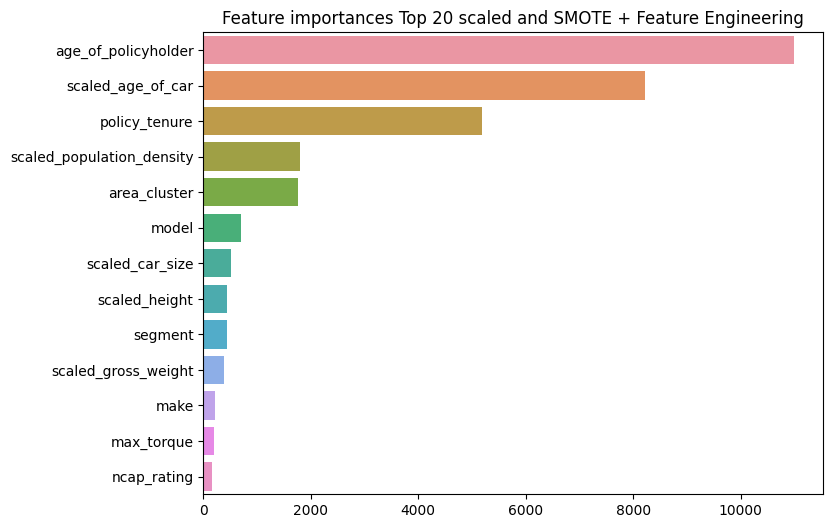

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = clf_lgbm.feature_importances_ ## feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=smote_train_x_rb.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20 scaled and SMOTE + Feature Engineering')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()